In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')
HTML('<style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [2]:
%matplotlib inline
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [3]:
import time
timestamp = time.strftime('%Y_%m_%d_%H_%M_%S')
print timestamp

2016_11_23_10_08_38


In [4]:
root_dir = './'

In [5]:
src_dir = os.path.join(root_dir, 'code')
# add the 'code' directory as one where we can import modules
# prepend it to the path so that it can mask mosubdules with the same name, i.e. eden
sys.path = [src_dir] + sys.path

In [6]:
out_data_dir = os.path.join(root_dir, timestamp)
if not os.path.exists(out_data_dir): os.mkdir(out_data_dir)

In [7]:
# configure logger
from eden.util import configure_logging
import logging
logger = logging.getLogger()
log_fname = os.path.join(out_data_dir, 'log.txt')
configure_logging(logger, verbosity=1, filename=log_fname)

In [8]:
from toolz import curry, compose, pipe, take

In [9]:
import requests

def save(text, full_out_file_name):
    with open(full_out_file_name, 'w') as f:
        for line in text:
            f.write("%s\n" % line.encode('utf8').strip())

def rfam_uri(family_id, out_data_dir):
    # retrieve the seed sequences from RFAM and save them to file
    uri = 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id) 
    rfam_dir = os.path.join(out_data_dir, 'RNA')
    fname = family_id + '.fa'
    if not os.path.exists(rfam_dir):
        os.mkdir(rfam_dir)
    full_out_file_name = os.path.join(rfam_dir, fname)
    if not os.path.isfile(full_out_file_name):
        text = requests.get(uri).text.split('\n')
        save(text, full_out_file_name)
    return full_out_file_name

In [10]:
rfam_id = 'RF00005' #tRNA
data = rfam_uri(rfam_id, out_data_dir)

from eden.converter.fasta import fasta_to_sequence
seqs = list(fasta_to_sequence(data))

Starting new HTTP connection (1): rfam.xfam.org


In [11]:
header, seq = seqs[3]
print header
print seq

AB013373.1/3754-3825
GCGGAAGUAGUUCAGUGGUAGAACACCACCUUGCCAAGGUGGGGGUCGCGGGUUCGAAUCCCGUCUUCCGCU


In [12]:
# setup
complexity=3
nbits=15

from RaSE import make_fold
fold = make_fold(window_size=70,
                  max_bp_span=70,
                  avg_bp_prob_cutoff=0.1,
                  hard_threshold=0.5,
                  max_num_edges=2,
                  no_lonely_bps=True,
                  nesting=True)

In [16]:
%%time
from RaSE import make_fold_vectorize, stability
fold_vectorize = make_fold_vectorize(complexity=complexity,nbits=nbits,fold=fold)
snips, scores = stability(seq, alphabet='ACGU',fold_vectorize=fold_vectorize)

print snips
print scores

AGCUUCAGGCGCGCCCCCAGAGCUCAAUAGGCCUUCCAACCCUUUGGUGCACCGUUGCCGAAUAUCCGGCGG
[0.94919268491730624, 0.34436716777871557, 0.21970168871524737, 0.25884485732894102, 0.27171200651709687, 0.32685281334242261, 0.40823649414296204, 0.33783747607206893, 0.32616948885898417, 0.39316429101489009, 0.29272511529628525, 0.54385497798055249, 0.47879780661717769, 0.25194908668986638, 0.30482277257042045, 0.40538681881443711, 0.40790721770498262, 0.40387531203133226, 0.37464508360495075, 0.32901795075152784, 0.29610645972568123, 0.42936656035037346, 0.39948862849028843, 0.27909070788067986, 0.40329176728883304, 0.33493373252201886, 0.26176767225152475, 0.42174176612589498, 0.25465844546283323, 0.27515273030385634, 0.44872574776744756, 0.41094251571062035, 0.25877896788637034, 0.40158826080304089, 0.4314904791142406, 0.52327308295283526, 0.26606981608059715, 0.25742119643738925, 0.30352055345258544, 0.3130643001185402, 0.30003319380526167, 0.27945412321678403, 0.39934074182379431, 0.4205470449551576, 0.433

In [45]:
from RaSE import rna_structural_stability_estimate
rase = curry(rna_structural_stability_estimate)(k=5, complexity=complexity, nbits=nbits, fold=fold)
for line in rase(seq): print(line)

             (((((((..((((.......)))).(((((((...))))))).....(((((.......)))))))))))).
  0 G A 0.95 .((((((..((((.......)))).(((((((...))))))).....(((((.......))))))))))).. 
  1 C G 0.34 .((.(((.......(((((.....)))))))).))..((((((((..(((((.......))))))))))))) 
  2 G C 0.22 .........((...(((((.....)))))...))...((((((((..(((((.......))))))))))))) *
  3 G U 0.26 ..(((((.......(((((.....))))))))))...((((((((..(((((.......))))))))))))) *
  4 A U 0.27 ((((.((..((((.......)))).(((((((...))))))).....(((((.......))))))).)))). 
  5 A C 0.33 (((((....((((.......)))).(((((((...))))))).....(((((.......)))))..))))). 
  6 G A 0.41 ((((((...((((.......)))).(((((((...))))))).....(((((.......))))).)))))). 
  7 U G 0.34 (((((((..((((.......)))).(((((((...))))))).....(((((.......)))))))))))). 
  8 A G 0.33 (((((((..((((.......)))).(((((((...))))))).....(((((.......)))))))))))). 
  9 G C 0.39 (((((((((((.....))))((...(((((((...)))))))...))(((((.......)))))))))))). 
 10 U G 0.29 (((((((.............((...((((

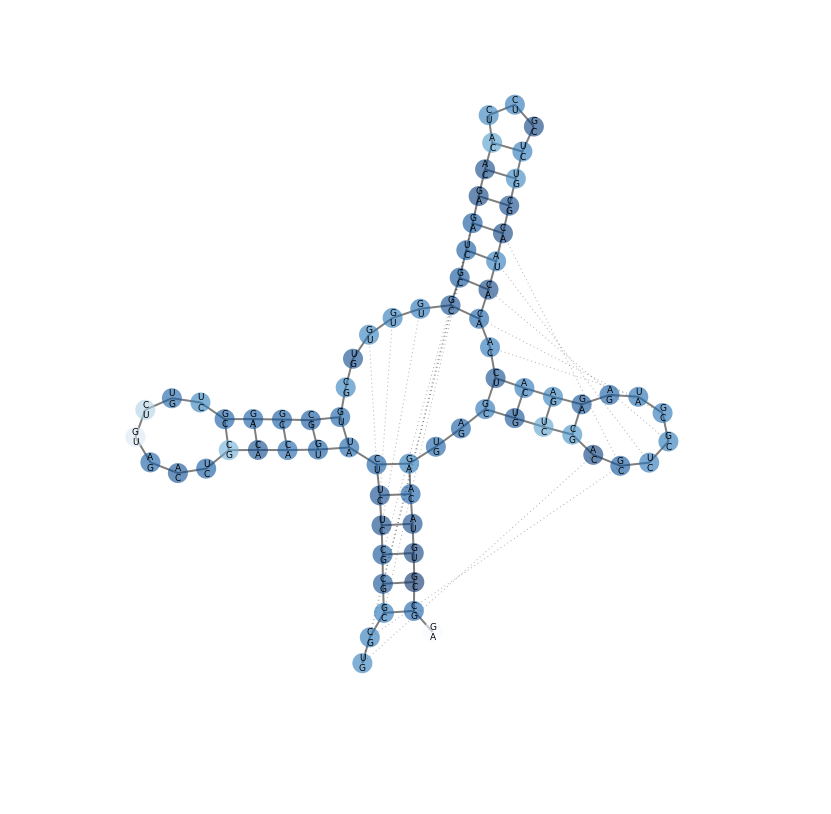

In [15]:
from RaSE import draw
draw(seq, fold=fold, complexity=complexity, nbits=nbits)

---